In [5]:
import os
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

In [6]:
# loading in the dataset
dataset = "/Users/nataliepegues/downloads/flower_dataset"

In [8]:
#image_size = (180, 180)
image_size = (224, 224)

batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    dataset,
    validation_split=0.2,
    subset="both",
    seed=1222,
    image_size=image_size,
    batch_size=batch_size,
)

Found 733 files belonging to 10 classes.
Using 587 files for training.
Using 146 files for validation.


2025-07-16 12:00:52.325674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


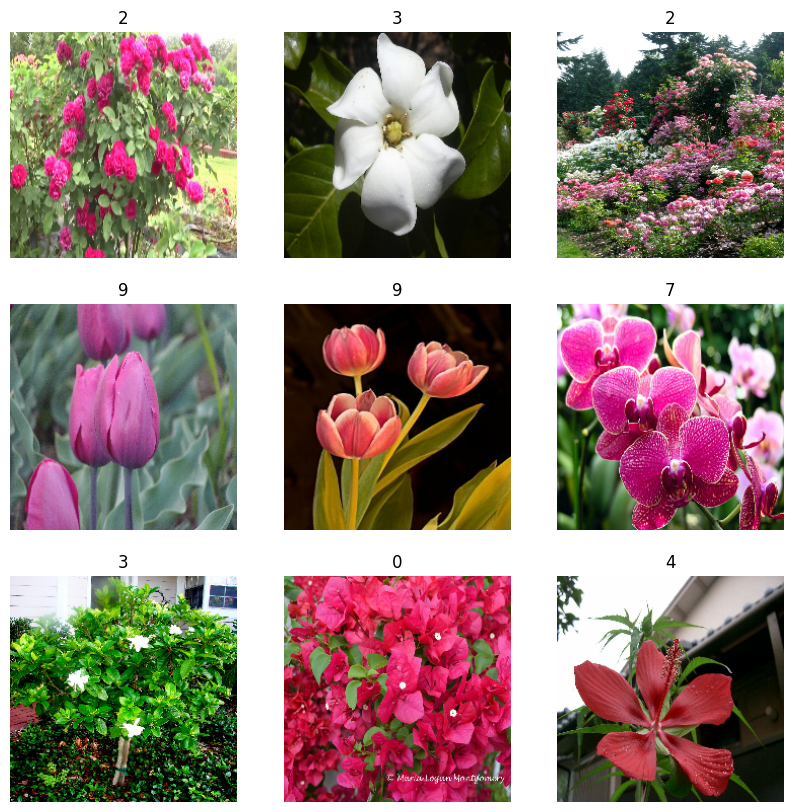

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [10]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-07-16 12:03:52.437853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


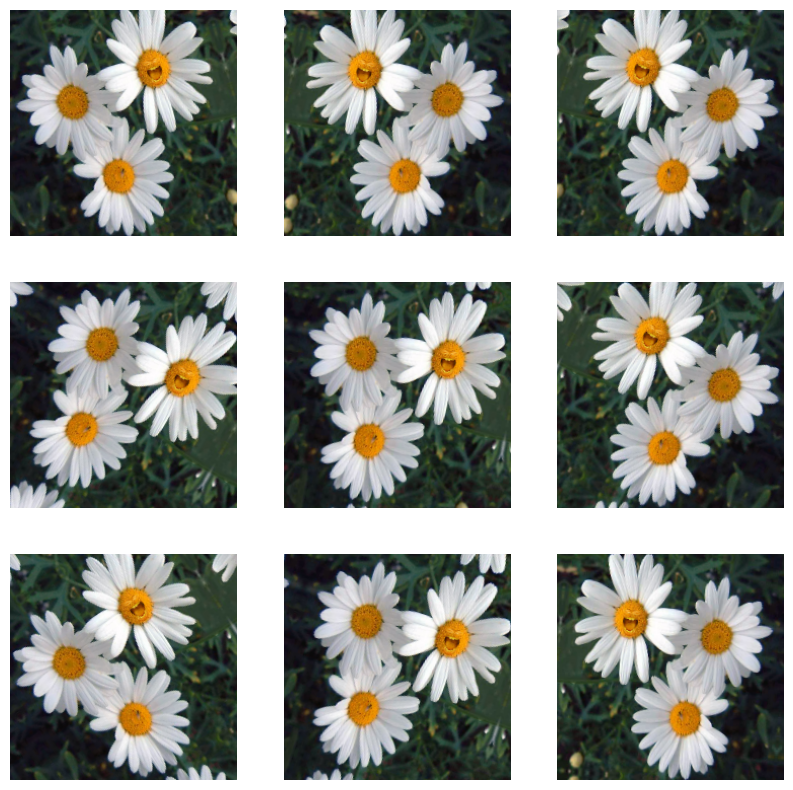

In [11]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [12]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [15]:
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - acc: 0.0918 - loss: -10.6252 - val_acc: 0.1096 - val_loss: -6.3076
Epoch 2/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - acc: 0.1169 - loss: -51.4509 - val_acc: 0.1096 - val_loss: -20.7388
Epoch 3/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - acc: 0.0952 - loss: -95.1508 - val_acc: 0.1096 - val_loss: -32.4523
Epoch 4/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - acc: 0.1348 - loss: -133.5324 - val_acc: 0.1096 - val_loss: -45.9197
Epoch 5/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - acc: 0.1278 - loss: -184.8195 - val_acc: 0.1096 - val_loss: -90.0763
Epoch 6/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - acc: 0.1381 - loss: -254.3410 - val_acc: 0.1096 - val_loss: -53.4197
Epoch 7/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 165s 3s/step - acc: 0.1166 - loss: -325.9169 - val_acc: 0.1096 - val_loss: -155.7025
Epoch 8/8
59/59 ━━━━━━━━━━━━━━━━━━━━ 178s 3s/step - acc: 0.1059 - loss: -421.4593 - val_acc: 0.1096 - val_loss: -256.0104


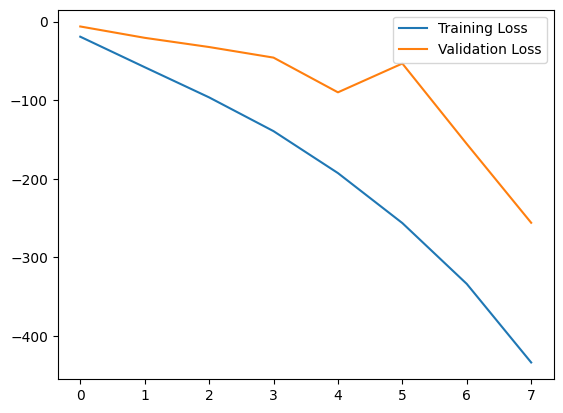

In [16]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

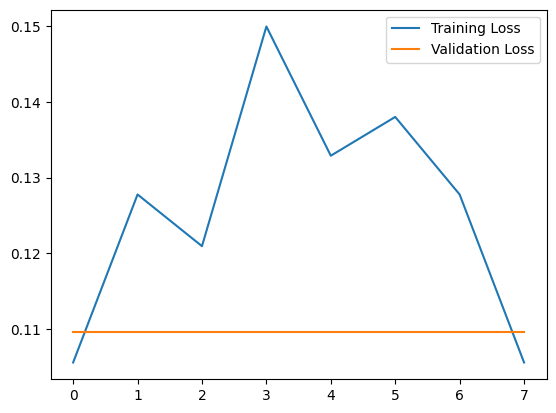

In [17]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Loss")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Loss")
plt.legend()